# Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pySODM.models.base import ODE
from covid19_DTM.data.utils import construct_initN
from covid19_DTM.models.TDPF import ramp_fun
from covid19_DTM.models.TDPF import make_seasonality_function
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data
import csv
from csv import DictReader
from matplotlib import font_manager
import string
import os
from functools import lru_cache

# Setup

In [2]:
abs_dir = os.getcwd()
result_folder = '../../results/QALY_model/postponed_healthcare/analysis/parameter_influences/'

label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=8)

In [3]:
start_sim = pd.to_datetime('2019-12-01')
end_sim = pd.to_datetime('2020-09-01')

plot_start_date = pd.to_datetime('2020-01-01')
plot_end_date = pd.to_datetime('2020-09-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

start_peak = pd.to_datetime('2020-02-01')
end_peak = pd.to_datetime('2020-05-01')
peak_amplitude = 100

In [4]:
def hypothetical_covid_peak_getH(t, states, param,start_peak,end_peak,peak_amplitude):

    mu = start_peak + (end_peak - start_peak)/2
    sigma = (end_peak - start_peak)/pd.Timedelta('1D') / 4

    covid_H = peak_amplitude * np.exp(-((t - mu)/pd.Timedelta('1D'))**2 / (2 * sigma**2))

    return covid_H

In [5]:
def hypothetical_covid_peak_getdH(t, states, param,start_peak,end_peak,peak_amplitude):
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    mu = start_peak + (end_peak - start_peak)/2
    sigma = (end_peak - start_peak)/pd.Timedelta('1D') / 4 

    covid_dH = -peak_amplitude * (t - mu)/pd.Timedelta('1D') * np.exp(-((t - mu)/pd.Timedelta('1D'))**2 / (2 * sigma**2)) / sigma**2

    return covid_dH

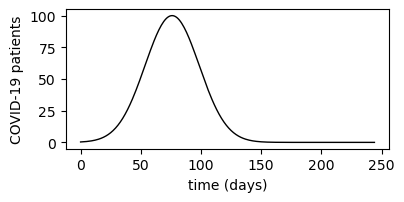

In [24]:
covid_H = []
for t in plot_time:
    mu = start_peak + (end_peak - start_peak)/2
    sigma = (end_peak - start_peak)/pd.Timedelta('1D') / 4  # Adjust the divisor for desired width
    covid_H.append(peak_amplitude * np.exp(-((t - mu)/pd.Timedelta('1D'))**2 / (2 * sigma**2)))

fig,ax = plt.subplots(figsize=(8.3/2,11.7/5.5))
ax.plot(range(len(plot_time)),covid_H,color='black',linewidth=1)
#ax.xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('COVID-19 patients',fontsize=10)
ax.set_xlabel('time (days)',fontsize=10)
ax.grid(False)
fig.tight_layout()
fig.savefig(os.path.join(result_folder,f'hypothetical_covid_peak.pdf'),bbox_inches='tight')

# Queuing model

In [7]:
from QALY_model.postponed_healthcare_models import Queuing_Model

# Define MDC classes to model
MDC = np.array(['03','05'])

# Define model parameters, initial states and coordinates
gamma = np.ones(len(MDC))*10
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))
alpha = 3

X_tot = 250

A = np.ones(len(MDC))*10
post_processed_H = (np.ones(len(MDC))*100,np.ones(len(MDC))*1)
params={'A':A,'f_UZG':0.5,'covid_H':0,'post_processed_H':post_processed_H,'X_tot':X_tot, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma, 'alpha':alpha,
'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude}

H_init = np.ones(len(MDC))*100

init_states = {'H':H_init,'H_adjusted':H_init,'H_norm':np.ones(len(MDC))}
coordinates={'MDC':MDC}

# Initialize model
model = Queuing_Model(init_states,params,coordinates=coordinates,time_dependent_parameters={'covid_H':hypothetical_covid_peak_getH})

In [8]:
alpha_choices = [1, 1.5, 2.0]

sigma_individual_choices = [1,10]
sigma_choices = []
for sigma in sigma_individual_choices:
    sigma_choices.append(np.where(MDC=='03',sigma,1))
print(sigma_choices)

epsilon_non_covid_choices = [0,0.01,0.1]
epsilon_choices = []
for epsilon in epsilon_non_covid_choices:
    epsilon_choices.append(np.where(MDC!='covid',epsilon,0))

default_parameters = {'alpha': 1.5, 'sigma': np.array([1,1]), 'epsilon': [0.01, 0.01]}
parameters = {'alpha':alpha_choices,'sigma':sigma_choices,'epsilon':epsilon_choices}

[array([1, 1]), array([10,  1])]


alpha
sigma
epsilon
                          a                   b                  c
alpha     53.77120594727143  177.93208803678618  337.1074119235109
sigma    177.93208803678618  199.17807707434815                NaN
epsilon                 0.0  177.93208803678618  375.5462173842317


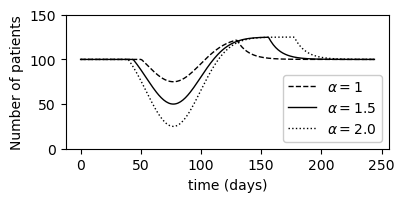

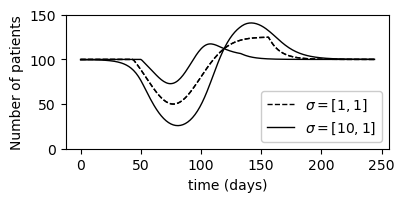

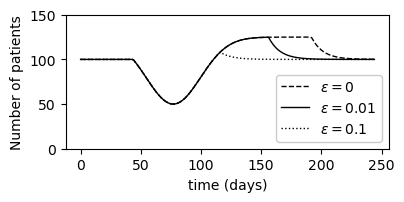

In [23]:
NR_table = pd.DataFrame(index=parameters.keys(),columns=['a','b','c'])

for parameter_name,parameter_choices in parameters.items():
    fig, ax = plt.subplots(1,1,figsize=(8.3/2,11.7/5.5))
    print(parameter_name)
    for i,(parameter_value,linestyle) in enumerate(zip(parameter_choices,['dashed','solid','dotted'])):
        model.parameters.update(default_parameters)
        model.parameters.update({parameter_name:parameter_value})
        out = model.sim([start_sim,end_sim],tau=1)
        NR_table[string.ascii_lowercase[i]][parameter_name]=out.NR[-1].sum().values
        out_plot = out.sel(MDC=disease,date=plot_time)['H']
        if parameter_name == 'alpha':
            ax.plot(range(len(plot_time)),out_plot,color='black',linestyle=linestyle,linewidth=1, label=f'$\{parameter_name}={parameter_value}$') 
        elif parameter_name == 'epsilon':
            ax.plot(range(len(plot_time)),out_plot,color='black',linestyle=linestyle,linewidth=1, label=f'$\{parameter_name}={parameter_value[0]}$') 
        elif parameter_name == 'sigma':
            for i,disease in enumerate(MDC):
                out_plot = out.sel(MDC=disease,date=plot_time)['H']
                if i ==0:
                    ax.plot(range(len(plot_time)),out_plot,color='black',linestyle=linestyle,linewidth=1, label=f'$\{parameter_name}=[{parameter_value[0]}, {parameter_value[1]}]$')
                else:
                    ax.plot(range(len(plot_time)),out_plot,color='black',linestyle=linestyle,linewidth=1, label=f'_$\{parameter_name}=[{parameter_value[0]}, {parameter_value[1]}]$')
    ax.legend(fontsize=10, framealpha=1, loc=4)
    ax.set_ylim([0,150])
    ax.set_xlabel('time (days)', fontsize=10)
    #ax.xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(False)
    ax.set_ylabel('Number of patients')
    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,f'queuing_model_{parameter_name}.pdf'),bbox_inches='tight')
    model.parameters.update({parameter_name:globals()[parameter_name]})
print(NR_table)
NR_table.to_csv(os.path.join(result_folder,'NR_table.csv'))

# Constrained PI model

In [37]:
from QALY_model.postponed_healthcare_models import Constrained_PI_Model

# Define MDC classes to model
MDC = np.array(['05'])

# Define model parameters, initial states and coordinates
alpha = (0.01*np.ones(1))
epsilon = (0.01*np.ones(1))

Kp = (0.05*np.ones(1))
Ki = (0.0005*np.ones(1))

covid_capacity = (20*np.ones(1))

params={'alpha':alpha,'epsilon':epsilon,'Kp':Kp,'Ki':Ki,'covid_capacity':covid_capacity,'covid_H':0,'covid_dH':0,'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude}

H_init = np.ones(len(MDC))*100

init_states = {'H_norm':np.ones(1),'E':np.zeros(1)}
coordinates={'MDC': MDC}

# Initialize model
model = Constrained_PI_Model(init_states,params,coordinates,time_dependent_parameters={'covid_H':hypothetical_covid_peak_getH,'covid_dH':hypothetical_covid_peak_getdH})

In [38]:
MDC = ['05',]

alpha_choices = [0.005,0.01,0.015]

epsilon_choices = [0,0.01,1]

covid_capacity_choices = [10,30,50]

Ki_choices = [0.0002,0.0005,0.0015]

Kp_choices = [0.02,0.05,0.2]

parameters = {'alpha':alpha_choices,'epsilon':epsilon_choices,'covid_capacity':covid_capacity_choices,'Ki':Ki_choices,'Kp':Kp_choices}

alpha
epsilon
covid_capacity
Ki
Kp


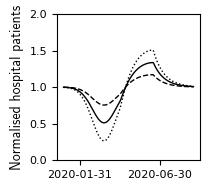

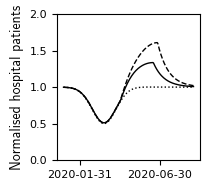

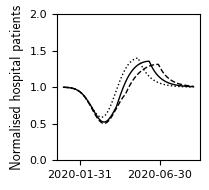

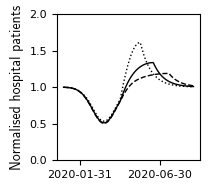

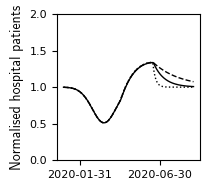

In [39]:
for parameter_name,parameter_choices in parameters.items():
    fig, ax = plt.subplots(figsize=(2.2,2))
    print(parameter_name)
    for i,(parameter_value,linestyle) in enumerate(zip(parameter_choices,['dashed','solid','dotted'])):
        model.parameters.update({parameter_name:parameter_value})
        out = model.sim([start_sim,end_sim],method='LSODA')
        out_plot = out.sel(MDC=disease,date=plot_time)['H_norm']
        ax.plot(plot_time,out_plot,color='black',linewidth=1,linestyle=linestyle)
        ax.set_ylim([0,2])
        ax.yaxis.set_ticks([0,0.5,1,1.5,2])
        ax.xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(False)
    ax.set_ylabel('Normalised hospital patients',font=label_font)
    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,f'constrained_PI_{parameter_name}'),dpi=600,bbox_inches='tight')
    model.parameters.update({parameter_name:globals()[parameter_name]})

# PI model

In [40]:
from QALY_model.postponed_healthcare_models import PI_Model

# Define MDC classes to model
MDC = np.array(['05'])

# Define model parameters, initial states and coordinates
alpha = (0.001*np.ones(1))
epsilon = (0.03*np.ones(1))

Kp = (0.02*np.ones(1))
Ki = (0.005*np.ones(1))

params={'alpha':alpha,'epsilon':epsilon,'Kp':Kp,'Ki':Ki,'covid_H':0,'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude}

init_states = {'H_norm':np.ones(1),'E':np.zeros(1)}
coordinates={'MDC': MDC}

# Initialize model
model = PI_Model(init_states,params,coordinates,time_dependent_parameters={'covid_H':hypothetical_covid_peak_getH})

In [41]:
MDC = ['05',]

alpha_choices = [0.0005,0.001,0.0015]

epsilon_choices = [0,0.03,0.1]

KI_choices = [0.002,0.005,0.02]

Kp_choices = [0,0.02,0.08]

parameters = {'alpha':alpha_choices,'epsilon':epsilon_choices,'Ki':KI_choices,'Kp':Kp_choices}

alpha
epsilon
Ki
Kp


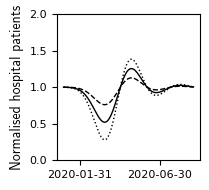

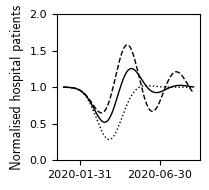

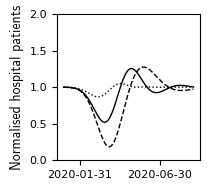

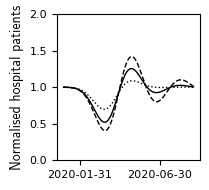

In [42]:
for parameter_name,parameter_choices in parameters.items():
    fig, ax = plt.subplots(figsize=(2.2,2))
    print(parameter_name)
    for i,(parameter_value,linestyle) in enumerate(zip(parameter_choices,['dashed','solid','dotted'])):
        model.parameters.update({parameter_name:parameter_value})
        out = model.sim([start_sim,end_sim])
        out_plot = out.sel(MDC=disease,date=plot_time)['H_norm']
        ax.plot(plot_time,out_plot,color='black',linewidth=1,linestyle=linestyle)
        ax.set_ylim([0,2])
        ax.yaxis.set_ticks([0,0.5,1,1.5,2])
        ax.xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
        ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(False)
    ax.set_ylabel('Normalised hospital patients',font=label_font)
    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,f'PI_{parameter_name}'),dpi=600,bbox_inches='tight')
    model.parameters.update({parameter_name:globals()[parameter_name]})